In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Step 1: Generate example data
num_train_examples = 20000
sequence_length = 8

batch_size = 64
num_epochs = 25
val_split = 0.2

rng = np.random.default_rng(2024)

In [2]:
# Generate random frequencies for sine waves
# we'll use 1.0 as the maximum Nyquist frequency and 0 = constant
frequencies = rng.uniform(0.02, 0.2, size=num_train_examples)
phase_offsets = rng.uniform(0.0, 2*np.pi, size=num_train_examples)
sequences = np.zeros((num_train_examples, sequence_length))

# Generate sine waves
for i in range(num_train_examples):
    sequences[i] = np.sin(2*np.pi*frequencies[i]* np.arange(sequence_length) + phase_offsets[i])

# Split sequences into input (first <sequence_length-1> elements) and labels (sequence_length>'th element)
x_train = sequences[:, :sequence_length-1]
y_train = sequences[:, sequence_length-1]


In [3]:
# Build the model
model = models.Sequential([
  layers.InputLayer(input_shape=x_train.shape[1:]), 
  layers.Dense(64, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(64, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(1)  # Single neuron for regression
])

# Compile the model
steps_per_epoch = int((1.0-val_split)*num_train_examples / batch_size)
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(1e-2, steps_per_epoch*num_epochs)
  
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule), # use tf.keras.optimizers.Adam on Intel / NVidia GPU
              loss='mean_squared_error'
             )

2024-02-08 12:45:34.765237: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-08 12:45:34.765255: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-08 12:45:34.765259: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-08 12:45:34.765285: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-08 12:45:34.765297: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
# Train the model
train_hist = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=val_split)

Epoch 1/25


2024-02-08 12:45:35.236097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 3s 9ms/step - loss: 0.1263 - val_loss: 0.3855
Epoch 2/25
250/250 [==============================] - 2s 8ms/step - loss: 0.0281 - val_loss: 0.4815
Epoch 3/25
250/250 [==============================] - 2s 8ms/step - loss: 0.0260 - val_loss: 0.1475
Epoch 4/25
250/250 [==============================] - 2s 8ms/step - loss: 0.0294 - val_loss: 0.0565
Epoch 5/25
250/250 [==============================] - 2s 9ms/step - loss: 0.0249 - val_loss: 0.0526
Epoch 6/25
250/250 [==============================] - 2s 8ms/step - loss: 0.0263 - val_loss: 0.0555
Epoch 7/25
250/250 [==============================] - 2s 8ms/step - loss: 0.0258 - val_loss: 0.1242
Epoch 8/25
250/250 [==============================] - 2s 8ms/step - loss: 0.0243 - val_loss: 0.0802
Epoch 9/25
250/250 [==============================] - 2s 8ms/step - loss: 0.0252 - val_loss: 0.0327
Epoch 10/25
250/250 [==============================] - 2s 8ms/step - loss: 0.0229 - val_loss: 0.0691
Epoch 11/2

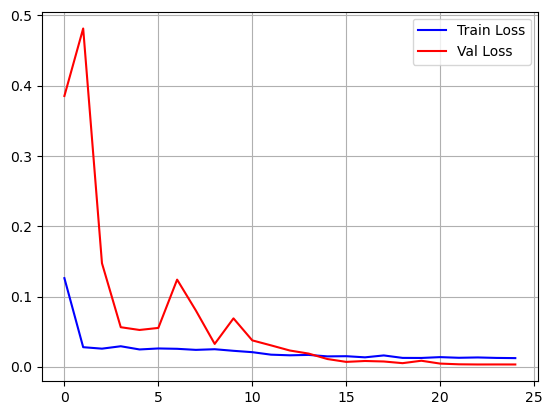

In [5]:
plt.plot(train_hist.epoch, train_hist.history['loss'], 'b-', label='Train Loss')
plt.plot(train_hist.epoch, train_hist.history['val_loss'], 'r-', label='Val Loss')
        

        
plt.legend()
plt.grid(True)

In [6]:
loss = model.evaluate(x_train, y_train)
print("Final training loss:", loss)

625/625 [==============================] - 2s 3ms/step - loss: 0.0037
Final training loss: 0.0036911407951265574


625/625 [==============================] - 1s 2ms/step


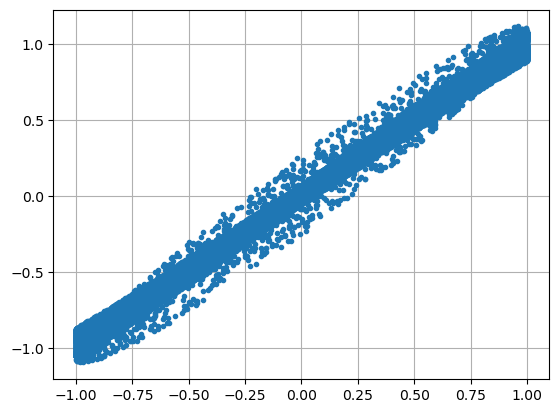

In [7]:
y_pred = model.predict(x_train)
plt.plot(y_train, y_pred, '.')
plt.grid(True)

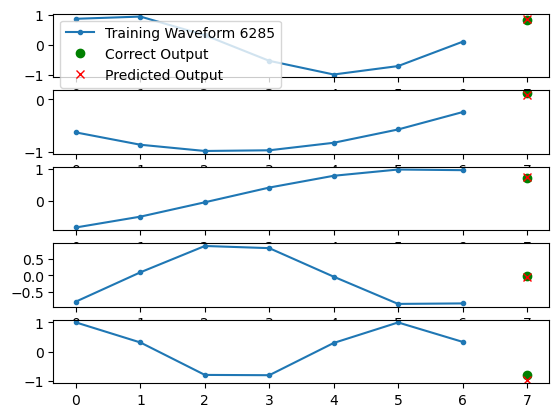

In [8]:
num_to_plot = 5
for i in range(5):
  plt.subplot(num_to_plot,1,i+1)
  index = rng.integers(low=0, high=num_train_examples)
  plt.plot(np.arange(sequence_length-1), x_train[i,:], '.-', 
           sequence_length-1, y_train[i], 'go',
           sequence_length-1, y_pred[i], 'rx'
          )
  if i == 0:
    # the legend obscures the data, so just show it once
    plt.legend([f"Training Waveform {index}", "Correct Output", "Predicted Output"])

In [9]:
model.save("sin_predictor.h5")

/Users/jeremy/miniforge3/envs/jh_main/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
